In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scienceplots
import warnings
warnings.filterwarnings("ignore")
plt.style.use('science')

In [2]:
models = {
    'harderLASSO ANN': {'color': 'black', 'marker': 'o', 'linestyle': 'solid', 'lw': 2,  'id': 0},
    'LASSO ANN': {'color': 'black', 'marker': '', 'linestyle': 'solid', 'lw': 2,  'id': 1},

    'harderLASSO linear': {'color': 'blue', 'marker': 'o', 'linestyle': 'solid', 'lw': 2, 'id': None},
    'LASSO linear': {'color': 'blue', 'marker': '', 'linestyle': 'solid', 'lw': 2, 'id': None},

    'LassoNet': {'color': 'orange', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 2},
    'RF': {'color': 'magenta', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 3},
    'XGBoost': {'color': 'green', 'marker': '', 'linestyle': 'solid', 'lw': 1, 'id': 4}
}

nonlinear_models = {key: item for key, item in models.items() if 'linear' not in key}

In [3]:
def data_processing(file_name):
    df = pd.read_csv(file_name)

    def convert_line(line):
        if isinstance(line, str):
            line = line.replace('array', 'np.array')
            line = eval(line, {"np": np, "float32": np.float32, "int64": np.int64})
        return line

    for column in df.drop('run_id', axis='columns').columns:
        df[column] = df[column].apply(convert_line)

    return df


def perf_measure(S_hat, S):
    S_hat = set(S_hat)
    S = set(S)
    if S_hat==S:
        return True, 1, 1, 0

    TP = len(S_hat & S)  # True Positives
    FP = len(S_hat - S)  # False Positives
    FN = len(S - S_hat)  # False Negatives
    F1 = TP/(TP+0.5*(FN+FP))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FDR = FP / (FP + TP) if (FP + TP) > 0 else 0

    return False, F1, TPR, FDR

def test_mse(mu_hat_x, mu_x):
    mse = (np.square(mu_hat_x - mu_x)).mean(axis=0)
    return np.sqrt(mse)


def compute_simulation_metrics_for_s(s, simu_name, models = models):
    data_dict = {}

    results_root = os.path.join(simu_name, 'results')
    df_other_models = data_processing(f"{results_root}/other_models/s{s}.csv")
    df_Lasso_models = data_processing(f"{results_root}/Lasso_models/s{s}.csv")
    df_results = pd.merge(df_other_models, df_Lasso_models, on='run_id', how='inner').reindex(columns=['run_id'] + list(models.keys()))

    true_features_df = pd.read_csv(f'{simu_name}/data/features_{s}.csv')

    for run_id in df_results['run_id']:
        true_features = true_features_df.iloc[:, run_id]
        df_run_id = df_results[df_results['run_id'] == run_id].iloc[0]
        for model in models:
            ### Features selection analysis ###
            selected_features = df_run_id[model][0]
            n_feat = len(selected_features)
            PESR, f1, TPR, FDR = perf_measure(selected_features, true_features)
            metrics = {'|S^|': n_feat, 'PESR': PESR, 'f1': f1, 'TPR': TPR, 'FDR': FDR, 'test error' : None}
            data_dict.setdefault(model, {metric : [] for metric in metrics})
            for metric in list(metrics.keys())[:-1]:
                data_dict[model][metric].append(metrics[metric])

            ### Predictive error analysis ###
            data_dict[model]['test error'].append(np.sqrt(df_run_id[model][1]))

    for model in models:
        data_dict[model] = {metric: np.mean(data_dict[model][metric]) for metric in metrics}

    return data_dict


def compute_simulation_metrics(simu_name, models=models):
    results = {}
    s_values = range(31) if simu_name == 'linear' else range(0, 21, 2)

    for s in s_values:
        results[s] = compute_simulation_metrics_for_s(s, simu_name, models)
    return results

In [4]:
def plot_simulation_metrics(results, models, s_range, exclude_models=[], x_ticks=None, figsize=(20, 6), dpi=300, save_path=None):
    x_ticks = s_range if x_ticks is None else x_ticks
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    metric_names = ['PESR', 'f1', 'test error']

    for model, style in models.items():
        if model in exclude_models:
            continue
        for ax, metric in zip(axes, metric_names):
            metric_values = [results[s][model][metric] for s in s_range]
            ax.plot(s_range, metric_values, label=model, color=style['color'],
                    marker=style['marker'], linestyle=style['linestyle'], lw=style['lw'], markersize=5)

    # Set axis labels and legends
    for ax, name in zip(axes, ['PESR', r'$F_1$', 'test error']):
        ax.set_xlabel('s')
        ax.set_ylabel(name)
        ax.set_xticks(x_ticks)
        ax.minorticks_off()

    plt.tight_layout()
    axes[2].legend(ncols=2, fontsize=13)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Linear Regression

### Phase transition: linear 
n=70, p=250 and snr=3, 100 simulations

In [5]:
linear_results = compute_simulation_metrics('linear')

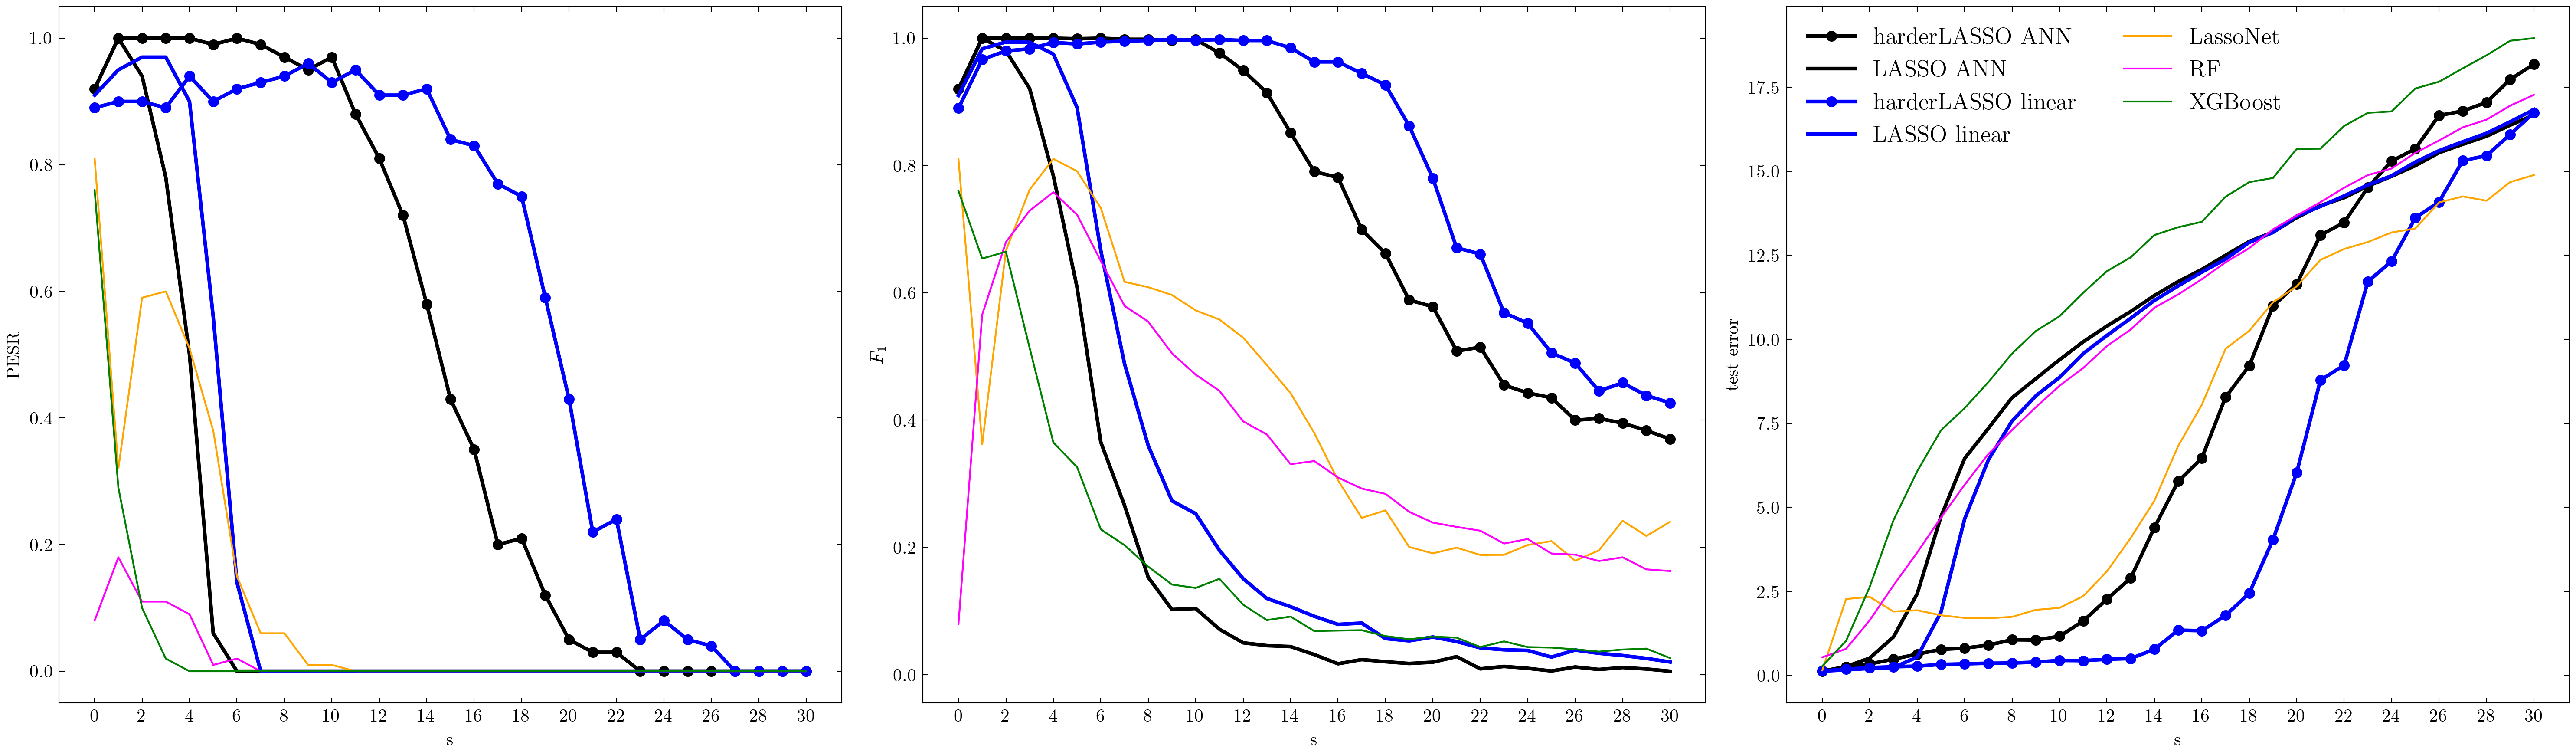

In [6]:
plot_simulation_metrics(linear_results, models, s_range=range(31), x_ticks=range(0,31,2), save_path='linear/linearsimuresults.pdf')

# Non linear regression

### Phase transition: non linear
n=500, p=50, SNR=10 and 100 simulations

In [7]:
nonlinear_results = compute_simulation_metrics('nonlinear', models = nonlinear_models)

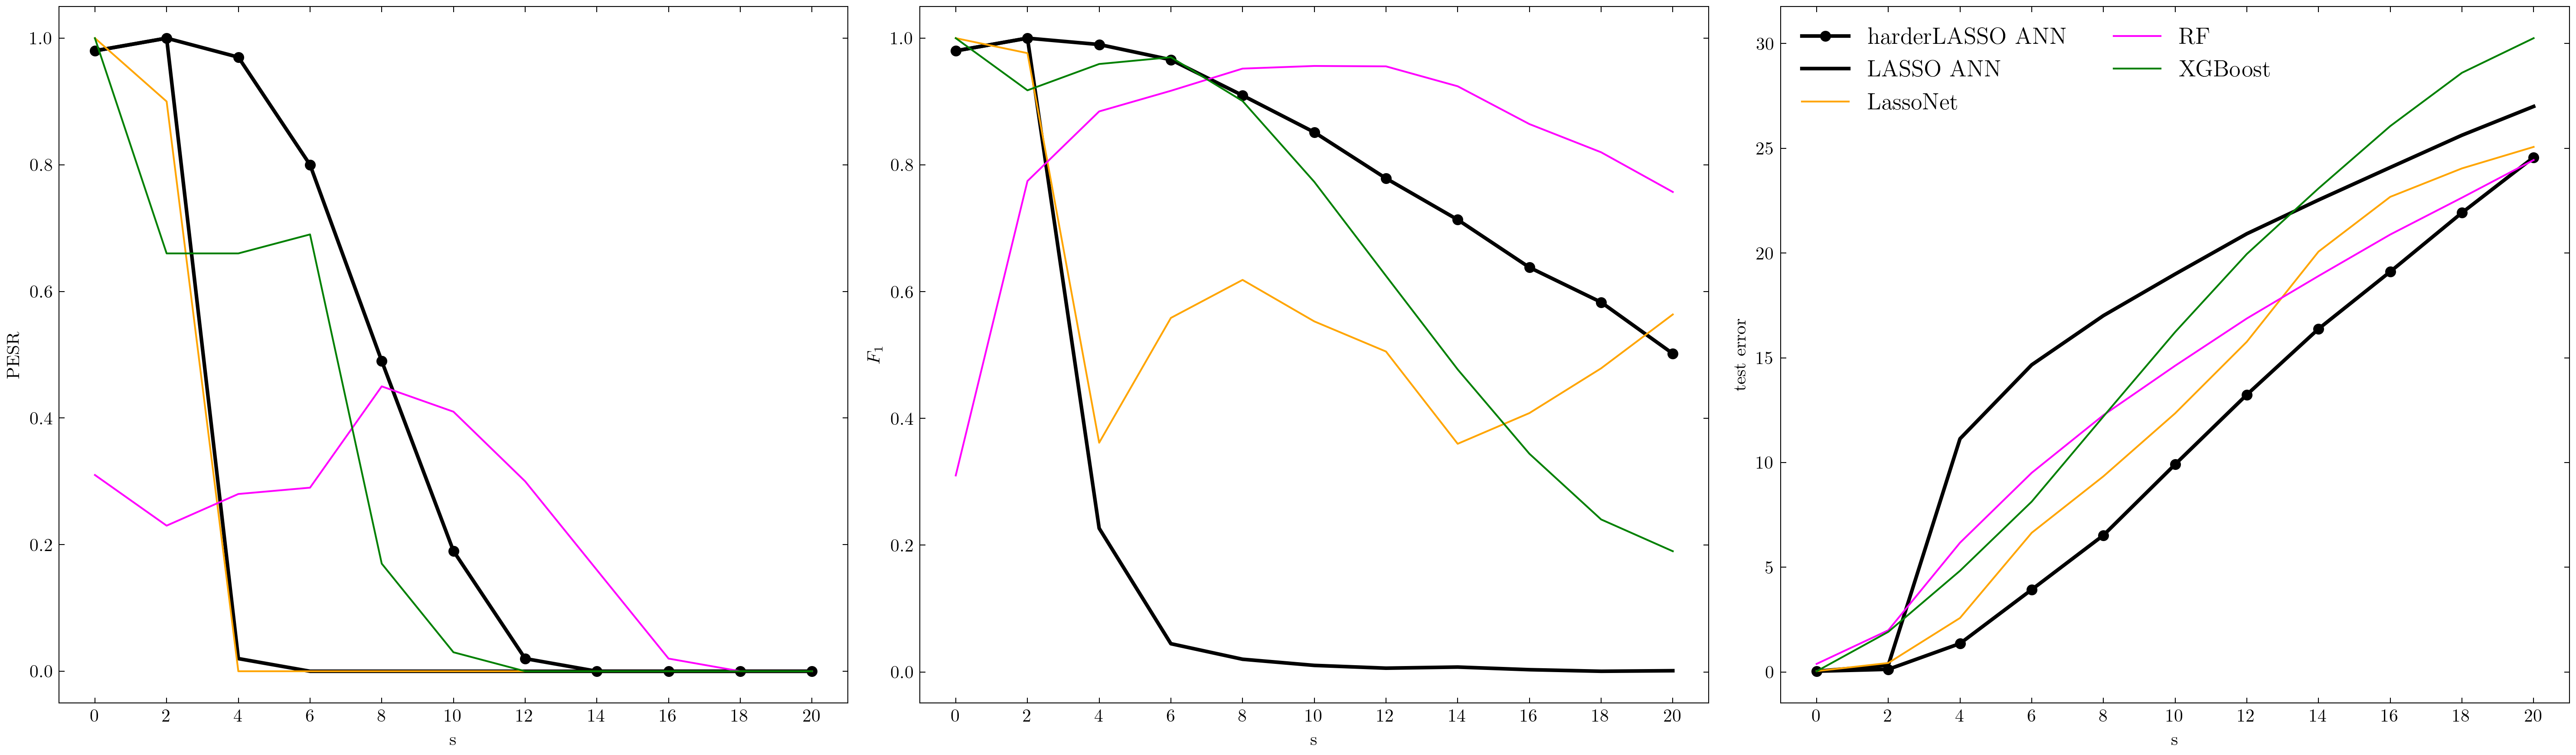

In [8]:
plot_simulation_metrics(nonlinear_results, nonlinear_models, range(0, 21, 2), save_path='nonlinear/nonlinearsimuresults.pdf')

# Parameters analysis

In [9]:
model_dfs = {}
models_lambda = ["harderLASSO ANN - 0.7lambda", "harderLASSO ANN - lambda", "harderLASSO ANN - 1.3lambda"]
for model in models_lambda:
    model_dfs[model] = pd.DataFrame()

for n in range(20, 110, 20):
    # Dictionary to store PESR values for each model and s value
    data_dict = {model: [] for model in models_lambda}

    for s in range(31):
        df_results = data_processing(f"parameters_analysis/results/n{n}/s{s}.csv")
        true_features_df = pd.read_csv(f"parameters_analysis/data/features_{s}.csv")

        for run_id in df_results['run_id']:
            true_features = true_features_df.iloc[:, run_id]
            df_run_id = df_results[df_results['run_id'] == run_id].iloc[0]

            for model in df_results.drop(columns='run_id').columns:
                selected_features = df_run_id[model]
                PESR = perf_measure(selected_features, true_features)[0]
                data_dict[model].append(PESR)

        for model in models_lambda:
            mean_pesr = np.mean(data_dict[model])  # Compute mean PESR for current s and n
            model_dfs[model].loc[s, n] = mean_pesr

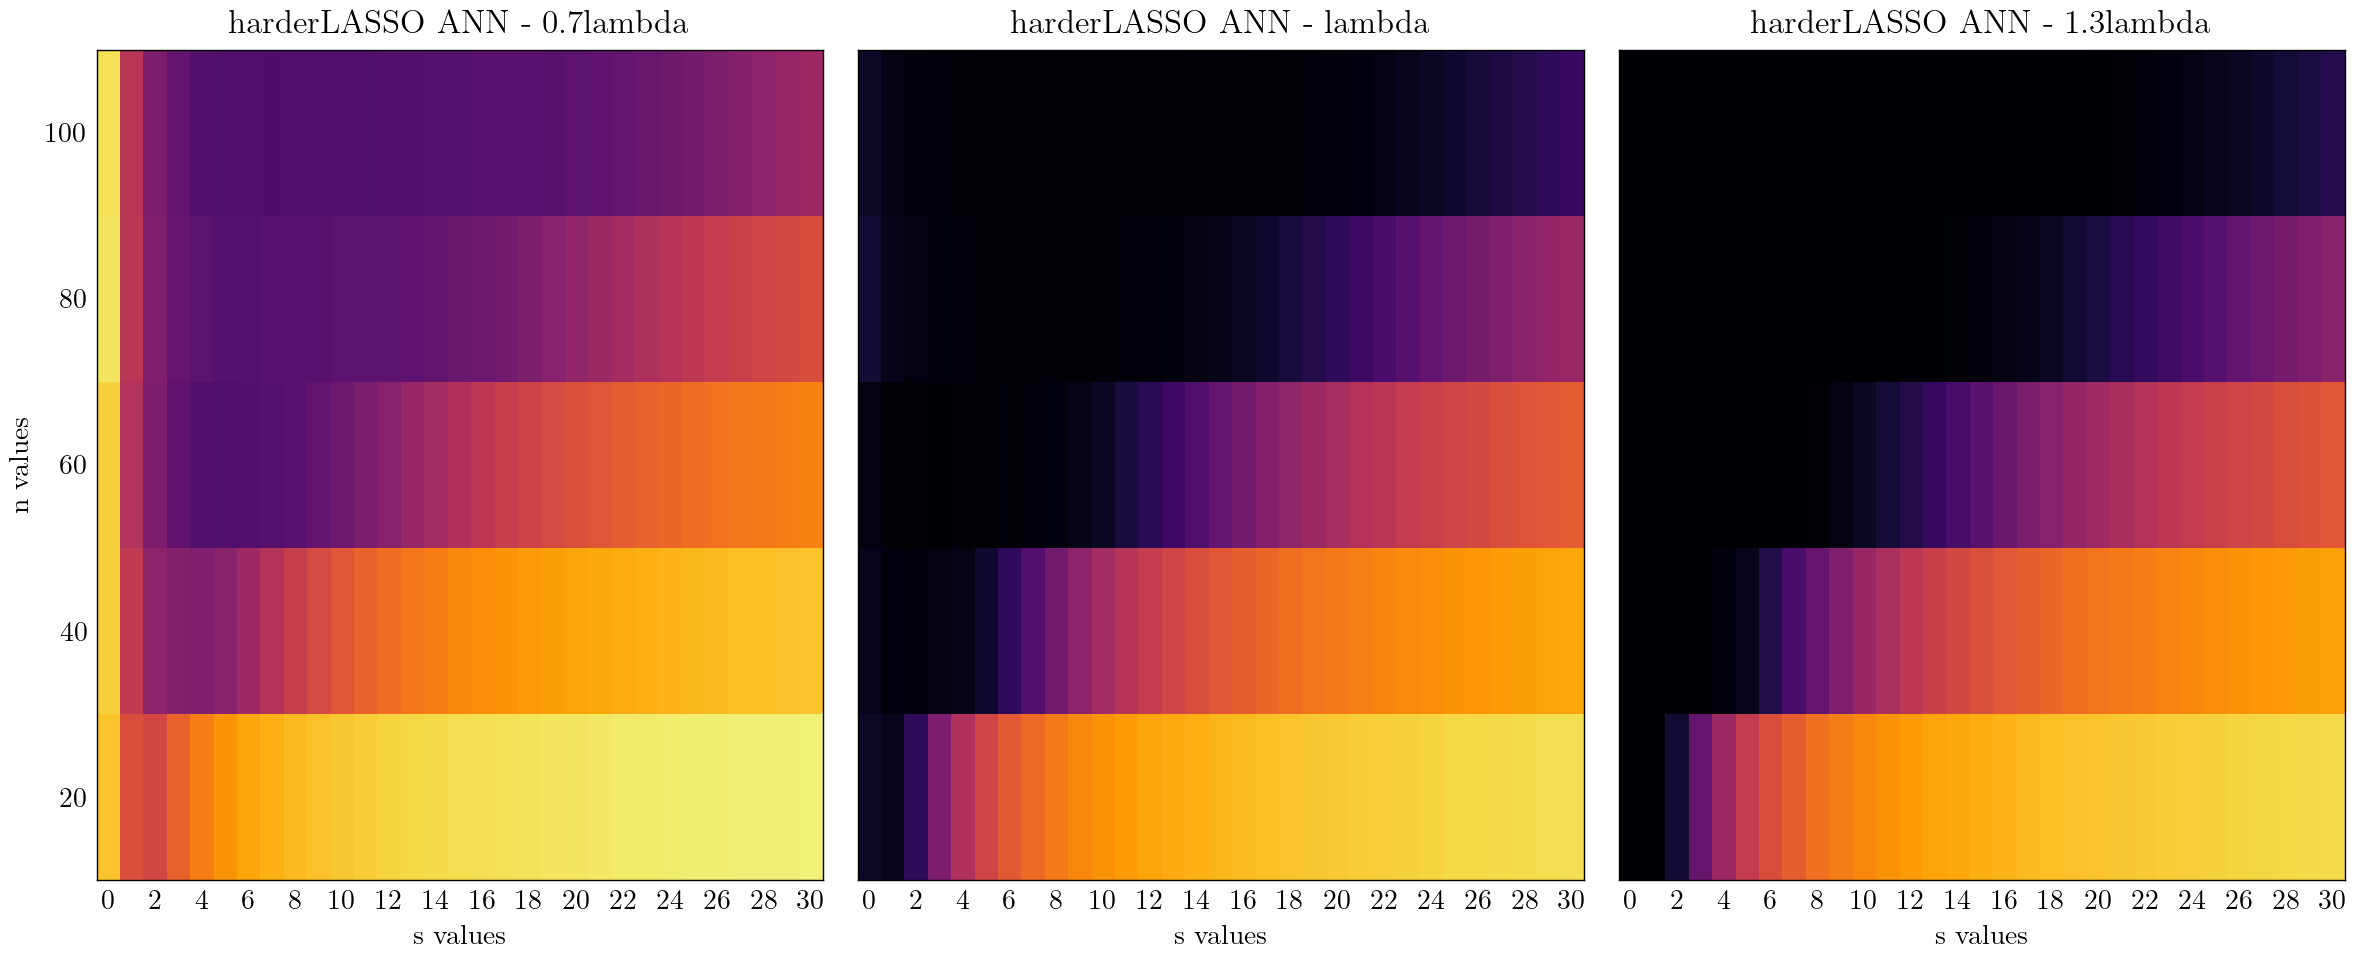

In [10]:
num_models = len(model_dfs)
fig, axes = plt.subplots(1, num_models, figsize=(12, 5), sharey=True, dpi=200)

for ax, (model, df) in zip(axes, model_dfs.items()):
    heatmap = ax.pcolor(df.T, vmin=0.0, vmax=1.0, cmap='inferno_r')
    ax.set_title(f"{model}")
    ax.set_xlabel("s values")

    ax.set_xticks([i + 0.5 for i in range(0, len(df.index), 2)])
    ax.set_xticklabels(range(0, len(df.index), 2))

    ax.set_yticks([i + 0.5 for i in range(len(df.columns))])
    ax.set_yticklabels(df.columns)

    ax.tick_params(axis='both', which='both', length=0)

axes[0].set_ylabel("n values")

plt.tight_layout()
plt.savefig("parameters_analysis/parameterssimuresults.pdf")
plt.show()

# Classification

In [11]:
from pathlib import Path

results, p_values = {}, {}

dataset_folders = ['biological_datasets', 'classical_datasets', 'other_datasets']
for dataset_folder in dataset_folders:
    dataset_path = Path(os.path.join("classification", dataset_folder))
    for subfolder in dataset_path.iterdir():
        if subfolder.is_dir():
            p = pd.read_csv(os.path.join(subfolder, 'data.csv')).shape[1]
            p_values[subfolder.name] = p

            # Paths to result files
            other_models_path = subfolder / 'results/other_models/results.csv'
            lasso_models_path = subfolder / 'results/Lasso_models/results.csv'

            # Check if both files exist
            if not other_models_path.exists() or not lasso_models_path.exists():
                print(f"Skipping {subfolder.name} as required result files are missing.")
                continue

            # Process files
            df_other_models = data_processing(other_models_path).drop(columns='baseline error')
            df_AnnLasso_models = data_processing(lasso_models_path).drop(columns='baseline error')

            df_results = pd.merge(df_other_models, df_AnnLasso_models, on='run_id').reindex(columns=['run_id'] + [model for model in models.keys() if 'linear' not in model])
            results[subfolder.name] = {
                model: (
                    np.mean([len(i[0]) for i in df_results[model]]),
                    round(np.mean([i[1] for i in df_results[model]]), 2)
                )
                for model in df_results.drop(["run_id"], axis='columns').columns
            }

# Create and fill the DataFrame with results
results_class = pd.DataFrame.from_dict(results, orient='index')
results_class.index.name = "Dataset"

results_class

,harderLASSO ANN,LASSO ANN,LassoNet,RF,XGBoost
Dataset,,,,,
obesity,"(3.0, 0.91)","(5.72, 0.72)","(15.28, 0.8)","(12.0, 0.95)","(12.5, 0.97)"
dry bean,"(5.54, 0.93)","(7.3, 0.92)","(16.0, 0.92)","(16.0, 0.92)","(13.0, 0.93)"
aids,"(3.28, 0.88)","(2.86, 0.85)","(19.74, 0.86)","(5.02, 0.85)","(6.5, 0.88)"
dna,"(9.06, 0.93)","(11.4, 0.94)","(157.42, 0.94)","(83.24, 0.96)","(18.22, 0.95)"
iris,"(1.64, 0.88)","(1.8, 0.74)","(2.64, 0.85)","(4.0, 0.95)","(2.04, 0.95)"
breast,"(2.02, 0.95)","(3.94, 0.97)","(26.94, 0.96)","(22.9, 0.96)","(9.6, 0.96)"
wine,"(2.18, 0.91)","(5.08, 0.96)","(10.92, 0.97)","(13.0, 0.98)","(7.08, 0.96)"
USPS,"(14.18, 0.86)","(49.54, 0.9)","(254.98, 0.94)","(208.8, 0.96)","(108.64, 0.96)"
mail,"(15.62, 0.92)","(24.96, 0.93)","(56.76, 0.94)","(19.68, 0.95)","(23.1, 0.95)"


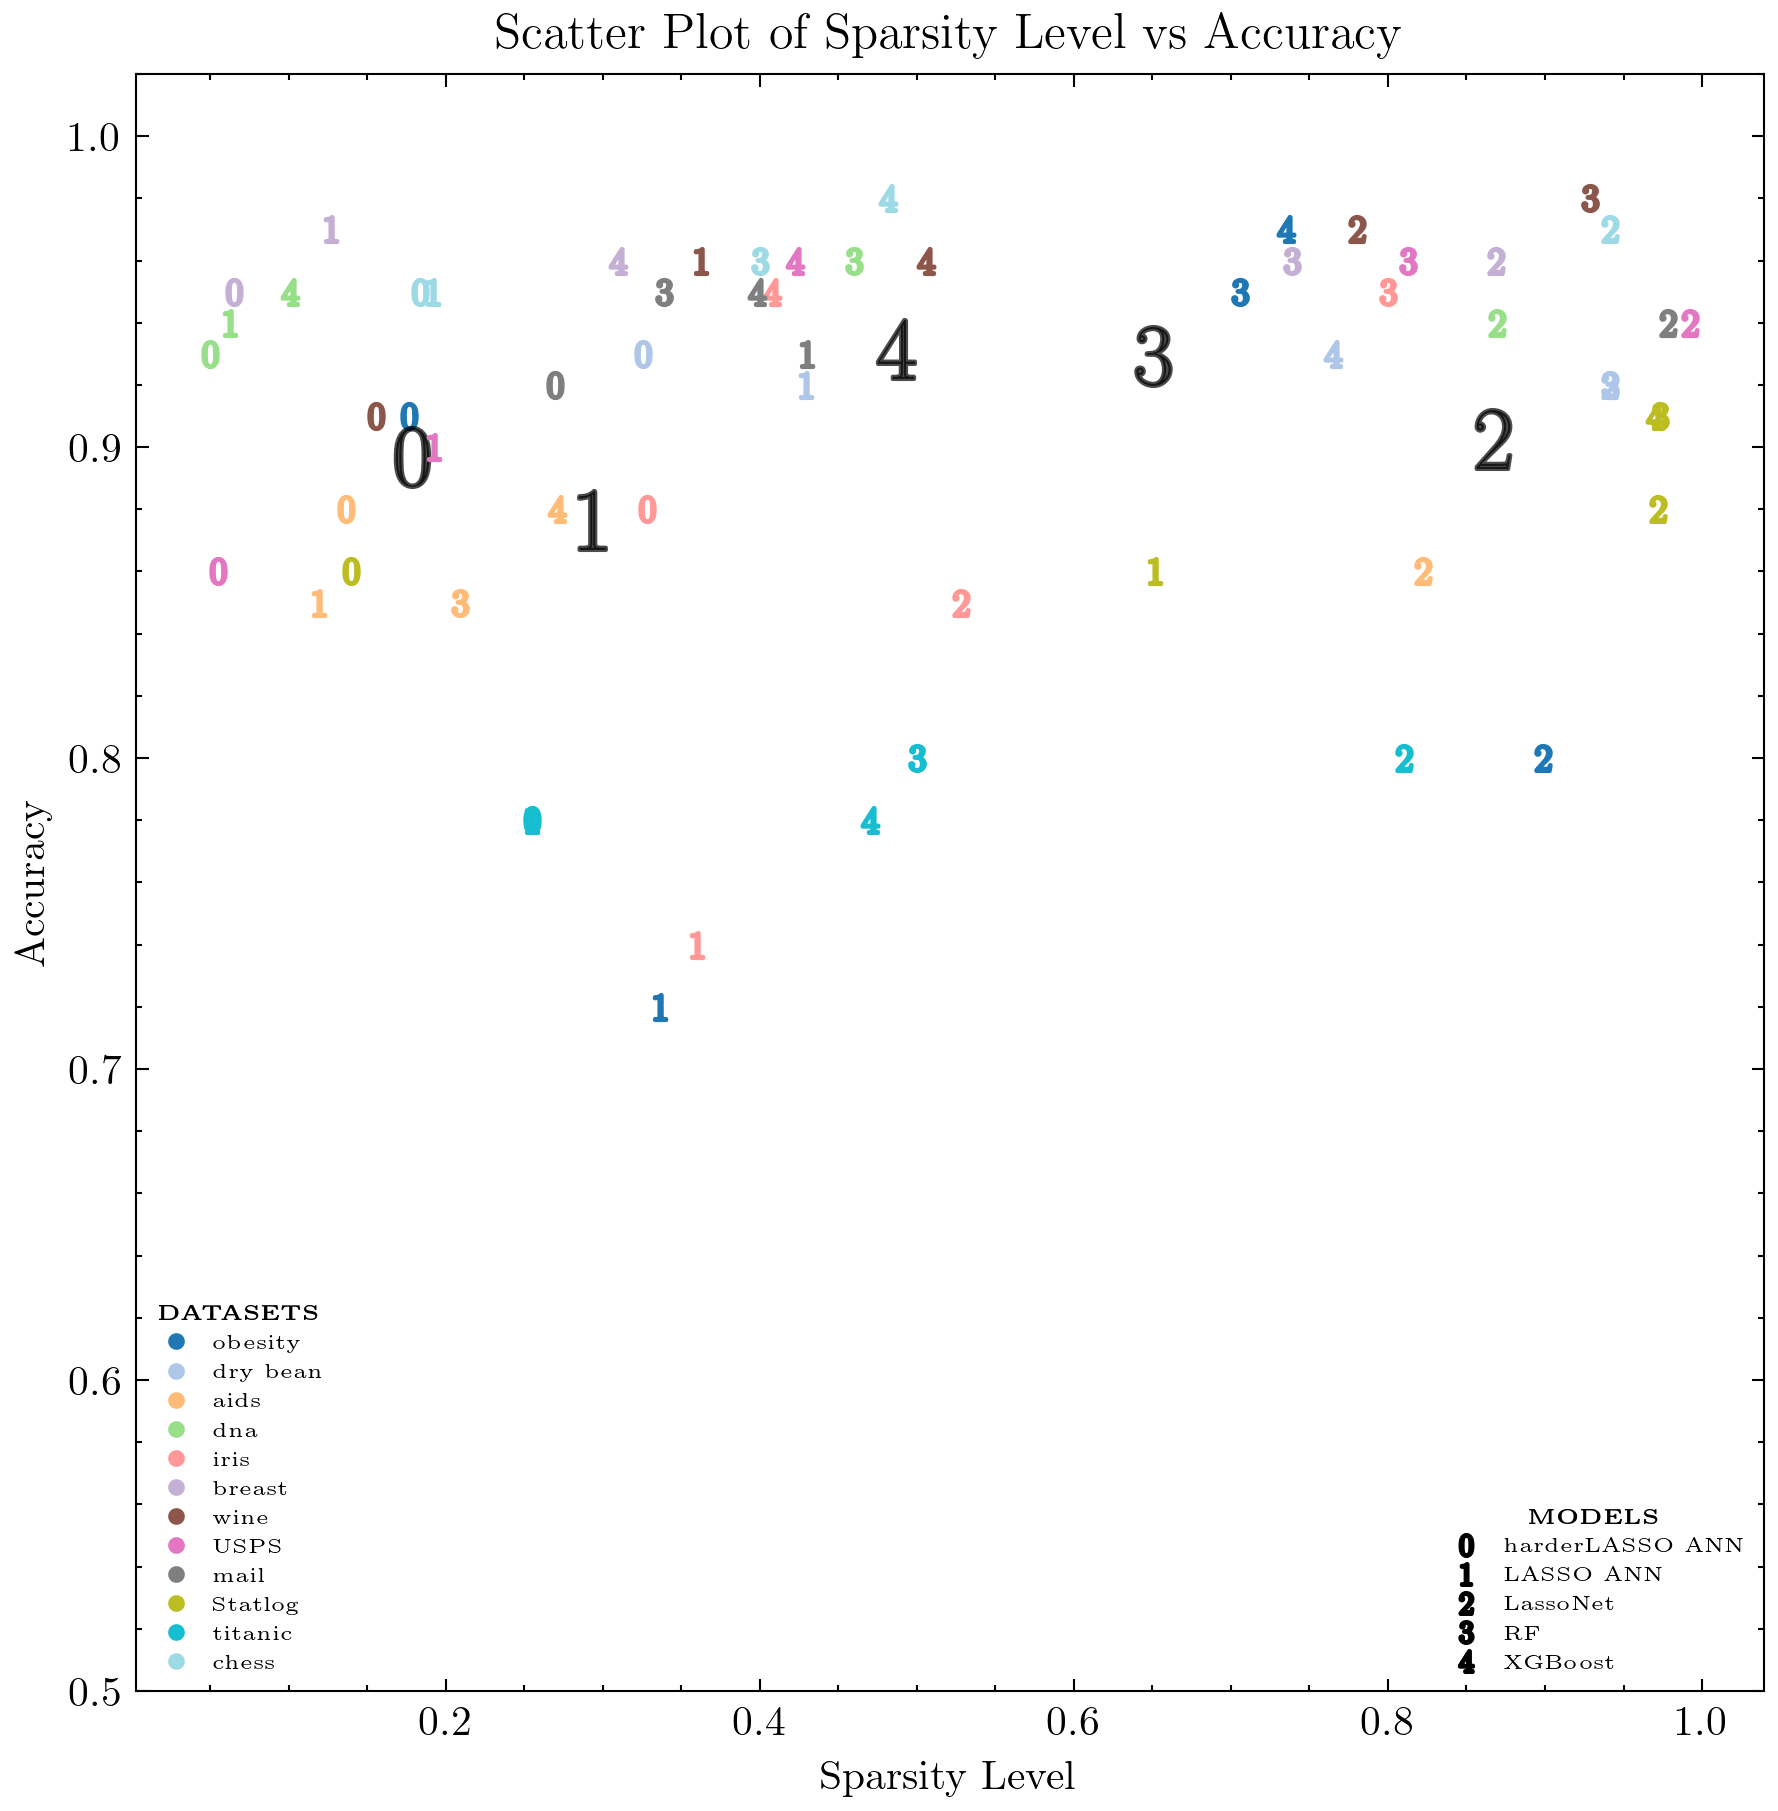

In [12]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

plt.figure(figsize=(7, 7), dpi=300)
plotted_models = results_class.columns
total_values = {}
datasets = results_class.index
datasets_colors = {dataset: color for dataset, color in zip(datasets, cm.get_cmap('tab20', len(datasets)).colors)}
plotted_datasets = set()

# Plot the data points
for model in plotted_models:
    total_values = []
    model_results = results_class[model]
    for dataset in datasets:
        sparsity_level = model_results[dataset][0]/p_values[dataset]
        accuracy = model_results[dataset][1]

        label = dataset if dataset not in plotted_datasets else None
        plt.scatter(sparsity_level, accuracy, c=[datasets_colors[dataset]],
                    marker="$" + str(models[model]['id']) + "$", label=label)
        total_values.append((sparsity_level, accuracy))
        plotted_datasets.add(dataset)

    a, b = (np.mean([i[0] for i in total_values]), np.mean([i[1] for i in total_values]))
    plt.scatter(a, b, c='black', marker="$" + str(models[model]['id']) + "$", s=200, alpha=0.7)

# Create the datasets legend
datasets_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=datasets_colors[dataset], markersize=5, label=dataset)
                   for dataset in datasets if dataset in plotted_datasets]
legend_datasets = plt.legend(handles=datasets_legend, title=r"\bf{DATASETS}", loc="lower left", fontsize=5, title_fontsize=5)

# Create the models legend
models_legend = [Line2D([0], [0], marker="$" + str(models[model]['id']) + "$", color='black', linestyle='None', markersize=5, label=model) for model in plotted_models]
legend_models = plt.legend(handles=models_legend, title=r"\bf{MODELS}", loc="lower right", fontsize=5, title_fontsize=5)

# Add the datasets legend back to the plot
plt.gca().add_artist(legend_datasets)

# Labels, title, and saving
plt.ylim(0.5, 1.02)
plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy")
plt.title("Scatter Plot of Sparsity Level vs Accuracy")
plt.savefig("classification/classificationsimuresults.pdf")
plt.show()

# Layers analysis

In [13]:
n_values = np.arange(100, 6600, 100)
data_dict = {}

# Load the true features for each run_id
true_features_df = pd.read_csv("layers_analysis/data/features.csv")

for n in n_values:
    data_dict[n] = {}
    df_AnnLasso_models = data_processing(f"layers_analysis/results/Lasso_models/n{n}.csv")
    df_other_models = data_processing(f"layers_analysis/results/other_models/n{n}.csv")

    df_results = pd.merge(df_other_models, df_AnnLasso_models, on='run_id')
    # Iterate over each run_id in the results DataFrame
    for run_id in df_results['run_id'].unique():
        # Extract the true features for this specific run_id
        true_features = true_features_df.iloc[:, run_id]
        df_run_id = df_results[df_results['run_id'] == run_id].iloc[0]

        # Iterate over each model in the DataFrame
        for model in df_results.columns.drop("run_id"):
            data_dict[n].setdefault(model, [])
            selected_features = df_run_id[model][0]
            test_error = np.sqrt(df_run_id[model][1])
            PESR, f1, TPR, FDR = perf_measure(selected_features, true_features)
            data_dict[n][model].append((PESR, test_error))

    # Average PESR and test error for each model
    for model in data_dict[n]:
        avg_PESR = np.mean([metrics[0] for metrics in data_dict[n][model]])
        avg_test_error = np.mean([metrics[1] for metrics in data_dict[n][model]])
        data_dict[n][model] = (avg_PESR, avg_test_error)

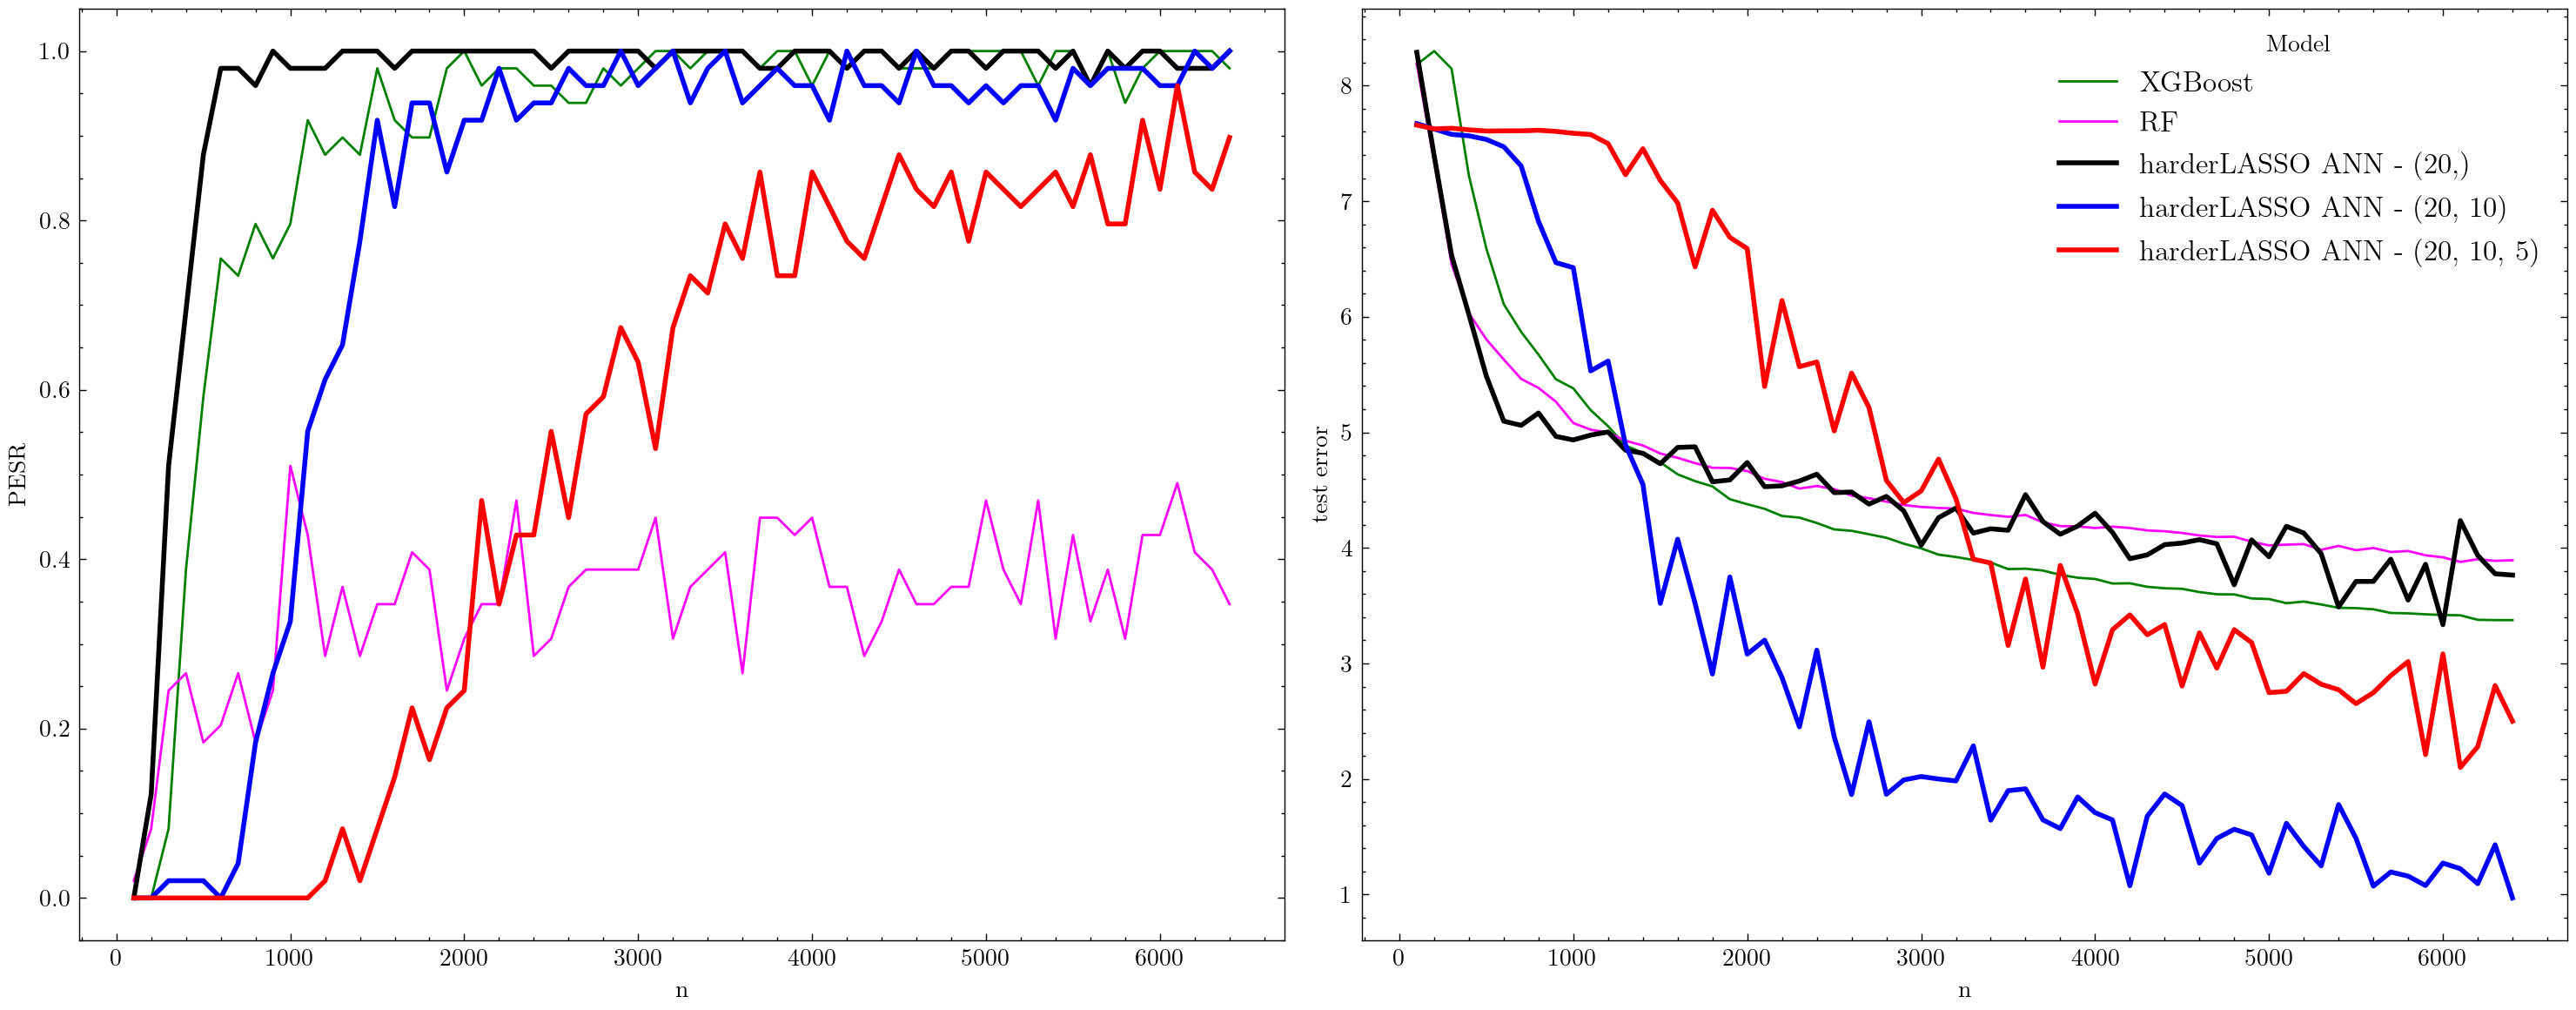

In [14]:
models_multiple_layers = {
    'harderLASSO ANN - (20,)': {'color': 'black', 'lw': 2},
    'harderLASSO ANN - (20, 10)': {'color': 'blue', 'lw': 2},
    'harderLASSO ANN - (20, 10, 5)': {'color': 'red', 'lw': 2},

    'RF': {'color': 'magenta', 'lw': 1},
    'XGBoost': {'color': 'green', 'lw': 1}
}

nonlinear_models = {key: item for key, item in models.items() if 'linear' not in key}

pesr_data = {n: {model: metrics[0] for model, metrics in models.items()} for n, models in data_dict.items()}
error_data = {n: {model: metrics[1] for model, metrics in models.items()} for n, models in data_dict.items()}

df_pesr = pd.DataFrame(pesr_data).T
df_error = pd.DataFrame(error_data).T

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=200, sharex=True)

for model in df_pesr.columns:
    color = models_multiple_layers[model]['color']
    lw = models_multiple_layers[model]['lw']

    axs[0].plot(df_pesr.index, df_pesr[model], label=model, color=color, linewidth=lw)
    axs[1].plot(df_error.index, df_error[model], label=model, color=color, linewidth=lw)

axs[0].set_xlabel('n')
axs[0].set_ylabel('PESR')

axs[1].set_xlabel('n')
axs[1].set_ylabel('test error')
axs[1].legend(title='Model', fontsize=12)

plt.tight_layout()
plt.savefig(f"layers_analysis/deepersimuresults.pdf")
plt.show()